# TC-Impact on Met: Weather Stations

Here we search the GSOD for weather stations near TC landfall to assess the impact of TC passage on the surface meteorology. 

The idea is to search for the nearest station that has ALL data present for landfall +/-30 days, and has at least k % completion for j years, and l % completion for the period +/- landfall within that ten-year period 

In [2]:
import ulmo as ul, numpy as np, pandas as pd,TC_Utils as tc, \
GeneralFunctions as GF, datetime as datetime, matplotlib.pyplot as plt, os, pickle
from netCDF4 import Dataset

/home/lunet/gytm3/anaconda2/lib/python2.7/site-packages/ulmo/twc/kbdi/core.py:20: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  CSV_SWITCHOVER = pandas.tslib.Timestamp('2016-10-01')


In [3]:
# Set parameters
minlen=10 # years of observations
minpc=70 # percentage complete over minlen period
maxdist=197 # maximum distance to search away from the TC (radius to 12 m/s wind [Chavas and Emmanuel, 2010])
min_frac=50.0 # GSOD Data be at least this complete to count as "complete (over 1981-2010)"
stdev=15/1.96

# Open the obs file (with landfall locations)
# strcture is: ID	YEAR	JD.JD	LAT	LON	GLAT	GLON	ROW	COL	DIST
tcdata=np.loadtxt("/media/gytm3/WD12TB/TropicalCyclones/TC-DeadlyHeat/Data/LandFall.txt",delimiter="\t",skiprows=1)

# Pull out landfall lat/lon
tclat=tcdata[:,3]; tclon=tcdata[:,4]
# Set the output file name. It will be a log with ID | LAT | LON | STATION ID | Distance
outfile="/media/gytm3/WD12TB/TropicalCyclones/TC-DeadlyHeat/Data/GSOD_Stations.txt"
outfile_silver="/media/gytm3/WD12TB/TropicalCyclones/TC-DeadlyHeat/Data/GSOD_Stations_silver.txt"
# Set the output directory to write the "complete GSOD data to"
odir="/media/gytm3/WD12TB/TropicalCyclones/TC-DeadlyHeat/Data/GSOD_Complete/"
odir_silver="/media/gytm3/WD12TB/TropicalCyclones/TC-DeadlyHeat/Data/GSOD_Passage/"
# Directory to write test files to
testdir="/media/gytm3/WD12TB/TropicalCyclones/TC-DeadlyHeat/Data/Testing/"

In [10]:
# Use ulmo to return meta data on ALL stations with data since 1979
all_stations=ul.ncdc.gsod.get_stations(start="1979-01-01 00:00:00")


In [565]:
all_stations["113580-99999"]["latitude"]

47.55

## Find stations that are close enough to TC landfall (within maxdist) and have SLP & HI data for the TC landfall dat (+/- 30 days)

In [334]:
# Use ulmo-modified code to extract met data for the station nearest the TC landfall
reload(tc)
ids=all_stations.keys() # station codes
latlon=np.array([[all_stations[ii]["latitude"],all_stations[ii]["longitude"]] for ii in ids],dtype=np.float) # coordinates
# Test now by extracting pressure 
outmet=[]
outmet_hit=[]
out_station=[]
dist_used=np.zeros((len(tcdata)))*np.nan
nsuc=0
with open(outfile,"w") as fo:
    
    # Write the header to the output file
    fo.write("YEAR\tMONTH\tDAY\tID\tLAT\tLON\tSTATION_ID\tDIST\n")
    
    for loc in range(len(tcdata)):

        # If all criteria are met, we'll not search any more; initialise to "search"
        dist=GF.haversine_fast(tclat[loc],tclon[loc],latlon[:,0],latlon[:,1],miles=False) # that's the distance
        order=np.argsort(dist)
        nearest=0
        mindist=dist[order[nearest]]
        keep_search=True
        while keep_search and mindist<maxdist:

            # Construct date index for this landfall location
            tc_date=datetime.date(year=int(tcdata[loc,1]),month=1,day=1)+datetime.timedelta(days=tcdata[loc,2]-1)
            tc_st=tc_date-datetime.timedelta(days=30)
            tc_end=tc_date+datetime.timedelta(days=30)

            # Now extract all data for the year (+/-1) of TC landfall for the station closest to landfall location
            startyr=tc_date.year-1; endyr=tc_date.year+1
            alldata,corevars=tc.get_gsod_data("/media/gytm3/WD12TB/GSOD",\
            [ids[order[nearest]],],startyr=int(startyr), endyr=int(endyr), parameters=None)

            # Check we have something!
            if len(corevars)>1:     

                # Compute HI. etc
                corevars["tempC"]=GF.Faren2C(corevars["mean_temp"])
                corevars["dewC"]=GF.Faren2C(corevars["dew_point"])
                corevars["rh"]=GF.dewVp(corevars["dewC"]+273.15)/GF.satVp(corevars["tempC"])*100.            
                corevars["specHum"]=GF.specHum(corevars["tempC"],corevars["rh"],corevars["slp"])
                corevars["hi"]=GF.HeatIndexNWS(corevars["tempC"],corevars["rh"],opt=False,iounit=np.array([0,0]))

                # Check for completion during "hit"
                hit_data=corevars[tc_st:tc_end]

                # Examine pressure and hi
                # Note these ranges should be constrained based on GSOD meta-data
                n_press=np.sum(np.logical_and(hit_data["slp"]!=9999.9,hit_data["slp"]!=9999.9))
                n_hi=np.sum(np.logical_and(hit_data["hi"]>-100,hit_data["hi"]<200))

                # Then all data here
                if n_press == 61 and n_hi == 61:
                    outmet.append(corevars)
                    outmet_hit.append(hit_data)
                    dist_used[loc]=dist[order[nearest]]
                    out_station.append(ids[order[nearest]])

                    # End search
                    keep_search=False; print "Found what we're after! [dist=%.1f; station=%s]" \
                    % (dist[order[nearest]],ids[order[nearest]])
                    nsuc+=1
                    
                    # Write a new line out
                    lout="%.0f\t%.0f\t%.0f\t%.0f\t%.2f\t%.2f\t%s\t%.2f\n" % \
                    (tc_date.year,tc_date.month,tc_date.day,\
                     tcdata[loc,0],tcdata[loc,3],tcdata[loc,4],ids[order[nearest]],dist[order[nearest]])
                    fo.write(lout); fo.flush()

            if keep_search:
                mindist=dist[order[nearest+1]]
                print "Didn't satisfy criteria [dist=%.1f]; moving to distance: %.1f" % \
                    (dist[order[nearest]],mindist)


            nearest+=1  
        print "Finished with loc %.0f" % loc
            





Didn't satisfy criteria [dist=67.8]; moving to distance: 133.0
Didn't satisfy criteria [dist=133.0]; moving to distance: 134.1
Didn't satisfy criteria [dist=134.1]; moving to distance: 214.2
Finished with loc 0
Didn't satisfy criteria [dist=14.5]; moving to distance: 16.4
Didn't satisfy criteria [dist=16.4]; moving to distance: 99.5
Didn't satisfy criteria [dist=99.5]; moving to distance: 103.3
Didn't satisfy criteria [dist=103.3]; moving to distance: 194.2
Didn't satisfy criteria [dist=194.2]; moving to distance: 225.0
Finished with loc 1
Didn't satisfy criteria [dist=57.5]; moving to distance: 89.3
Didn't satisfy criteria [dist=89.3]; moving to distance: 122.7
Didn't satisfy criteria [dist=122.7]; moving to distance: 123.6
Didn't satisfy criteria [dist=123.6]; moving to distance: 159.5
Didn't satisfy criteria [dist=159.5]; moving to distance: 167.5
Didn't satisfy criteria [dist=167.5]; moving to distance: 189.3
Didn't satisfy criteria [dist=189.3]; moving to distance: 218.6
Finished 

Didn't satisfy criteria [dist=113.0]; moving to distance: 120.0
Didn't satisfy criteria [dist=120.0]; moving to distance: 140.6
Didn't satisfy criteria [dist=140.6]; moving to distance: 140.8
Didn't satisfy criteria [dist=140.8]; moving to distance: 151.5
Didn't satisfy criteria [dist=151.5]; moving to distance: 190.6
Didn't satisfy criteria [dist=190.6]; moving to distance: 198.2
Finished with loc 20
Didn't satisfy criteria [dist=18.6]; moving to distance: 71.5
Didn't satisfy criteria [dist=71.5]; moving to distance: 71.9
Didn't satisfy criteria [dist=71.9]; moving to distance: 90.4
Didn't satisfy criteria [dist=90.4]; moving to distance: 92.1
Didn't satisfy criteria [dist=92.1]; moving to distance: 95.7
Didn't satisfy criteria [dist=95.7]; moving to distance: 98.0
Found what we're after! [dist=98.0; station=984400-99999]
Finished with loc 21
Didn't satisfy criteria [dist=109.8]; moving to distance: 111.5
Didn't satisfy criteria [dist=111.5]; moving to distance: 120.9
Didn't satisfy c

Didn't satisfy criteria [dist=99.6]; moving to distance: 118.9
Didn't satisfy criteria [dist=118.9]; moving to distance: 119.5
Didn't satisfy criteria [dist=119.5]; moving to distance: 128.0
Didn't satisfy criteria [dist=128.0]; moving to distance: 138.3
Didn't satisfy criteria [dist=138.3]; moving to distance: 151.2
Didn't satisfy criteria [dist=151.2]; moving to distance: 153.0
Didn't satisfy criteria [dist=153.0]; moving to distance: 178.3
Didn't satisfy criteria [dist=178.3]; moving to distance: 186.0
Didn't satisfy criteria [dist=186.0]; moving to distance: 187.5
Didn't satisfy criteria [dist=187.5]; moving to distance: 208.9
Finished with loc 34
Didn't satisfy criteria [dist=34.3]; moving to distance: 43.0
Didn't satisfy criteria [dist=43.0]; moving to distance: 52.4
Didn't satisfy criteria [dist=52.4]; moving to distance: 52.4
Didn't satisfy criteria [dist=52.4]; moving to distance: 60.5
Didn't satisfy criteria [dist=60.5]; moving to distance: 60.9
Didn't satisfy criteria [dist=

Didn't satisfy criteria [dist=39.7]; moving to distance: 42.1
Didn't satisfy criteria [dist=42.1]; moving to distance: 42.1
Found what we're after! [dist=42.1; station=747770-03852]
Finished with loc 55
Didn't satisfy criteria [dist=21.1]; moving to distance: 24.3
Didn't satisfy criteria [dist=24.3]; moving to distance: 61.0
Didn't satisfy criteria [dist=61.0]; moving to distance: 61.1
Didn't satisfy criteria [dist=61.1]; moving to distance: 110.4
Didn't satisfy criteria [dist=110.4]; moving to distance: 111.1
Didn't satisfy criteria [dist=111.1]; moving to distance: 124.2
Found what we're after! [dist=124.2; station=984440-99999]
Finished with loc 56
Didn't satisfy criteria [dist=24.6]; moving to distance: 37.4
Didn't satisfy criteria [dist=37.4]; moving to distance: 59.7
Didn't satisfy criteria [dist=59.7]; moving to distance: 63.9
Didn't satisfy criteria [dist=63.9]; moving to distance: 72.2
Didn't satisfy criteria [dist=72.2]; moving to distance: 84.9
Didn't satisfy criteria [dist=

Found what we're after! [dist=136.9; station=943000-99999]
Finished with loc 81
Found what we're after! [dist=9.3; station=478380-99999]
Finished with loc 82
Didn't satisfy criteria [dist=50.6]; moving to distance: 81.4
Didn't satisfy criteria [dist=81.4]; moving to distance: 91.8
Didn't satisfy criteria [dist=91.8]; moving to distance: 96.9
Didn't satisfy criteria [dist=96.9]; moving to distance: 104.5
Didn't satisfy criteria [dist=104.5]; moving to distance: 188.5
Didn't satisfy criteria [dist=188.5]; moving to distance: 190.1
Didn't satisfy criteria [dist=190.1]; moving to distance: 190.8
Didn't satisfy criteria [dist=190.8]; moving to distance: 205.5
Finished with loc 83
Didn't satisfy criteria [dist=33.1]; moving to distance: 34.7
Didn't satisfy criteria [dist=34.7]; moving to distance: 55.9
Didn't satisfy criteria [dist=55.9]; moving to distance: 61.0
Didn't satisfy criteria [dist=61.0]; moving to distance: 84.9
Didn't satisfy criteria [dist=84.9]; moving to distance: 127.2
Didn'

Didn't satisfy criteria [dist=95.7]; moving to distance: 117.0
Didn't satisfy criteria [dist=117.0]; moving to distance: 119.9
Found what we're after! [dist=119.9; station=953170-99999]
Finished with loc 107
Didn't satisfy criteria [dist=43.2]; moving to distance: 50.0
Found what we're after! [dist=50.0; station=984460-99999]
Finished with loc 108
Didn't satisfy criteria [dist=30.0]; moving to distance: 33.3
Didn't satisfy criteria [dist=33.3]; moving to distance: 33.8
Found what we're after! [dist=33.8; station=722106-12835]
Finished with loc 109
Found what we're after! [dist=37.9; station=478170-99999]
Finished with loc 110
Didn't satisfy criteria [dist=6.3]; moving to distance: 20.7
Found what we're after! [dist=20.7; station=478090-99999]
Finished with loc 111
Didn't satisfy criteria [dist=114.4]; moving to distance: 115.6
Didn't satisfy criteria [dist=115.6]; moving to distance: 121.3
Didn't satisfy criteria [dist=121.3]; moving to distance: 132.0
Didn't satisfy criteria [dist=132

Found what we're after! [dist=140.7; station=747686-99999]
Finished with loc 115
Didn't satisfy criteria [dist=23.5]; moving to distance: 26.3
Didn't satisfy criteria [dist=26.3]; moving to distance: 26.3
Didn't satisfy criteria [dist=26.3]; moving to distance: 27.1
Didn't satisfy criteria [dist=27.1]; moving to distance: 33.0
Didn't satisfy criteria [dist=33.0]; moving to distance: 41.4
Didn't satisfy criteria [dist=41.4]; moving to distance: 42.5
Didn't satisfy criteria [dist=42.5]; moving to distance: 42.5
Didn't satisfy criteria [dist=42.5]; moving to distance: 42.9
Didn't satisfy criteria [dist=42.9]; moving to distance: 42.9
Didn't satisfy criteria [dist=42.9]; moving to distance: 43.3
Didn't satisfy criteria [dist=43.3]; moving to distance: 45.1
Didn't satisfy criteria [dist=45.1]; moving to distance: 45.2
Didn't satisfy criteria [dist=45.2]; moving to distance: 48.8
Didn't satisfy criteria [dist=48.8]; moving to distance: 53.6
Didn't satisfy criteria [dist=53.6]; moving to dist

Didn't satisfy criteria [dist=82.4]; moving to distance: 82.4
Didn't satisfy criteria [dist=82.4]; moving to distance: 102.8
Didn't satisfy criteria [dist=102.8]; moving to distance: 103.6
Didn't satisfy criteria [dist=103.6]; moving to distance: 103.6
Found what we're after! [dist=103.6; station=591580-99999]
Finished with loc 120
Didn't satisfy criteria [dist=15.3]; moving to distance: 15.7
Didn't satisfy criteria [dist=15.7]; moving to distance: 16.7
Didn't satisfy criteria [dist=16.7]; moving to distance: 16.7
Didn't satisfy criteria [dist=16.7]; moving to distance: 18.2
Didn't satisfy criteria [dist=18.2]; moving to distance: 46.9
Didn't satisfy criteria [dist=46.9]; moving to distance: 46.9
Didn't satisfy criteria [dist=46.9]; moving to distance: 48.7
Didn't satisfy criteria [dist=48.7]; moving to distance: 49.3
Didn't satisfy criteria [dist=49.3]; moving to distance: 146.1
Didn't satisfy criteria [dist=146.1]; moving to distance: 171.6
Didn't satisfy criteria [dist=171.6]; movin

Found what we're after! [dist=110.3; station=670950-99999]
Finished with loc 136
Didn't satisfy criteria [dist=6.5]; moving to distance: 31.3
Didn't satisfy criteria [dist=31.3]; moving to distance: 39.3
Didn't satisfy criteria [dist=39.3]; moving to distance: 98.8
Didn't satisfy criteria [dist=98.8]; moving to distance: 126.3
Didn't satisfy criteria [dist=126.3]; moving to distance: 131.7
Didn't satisfy criteria [dist=131.7]; moving to distance: 134.1
Didn't satisfy criteria [dist=134.1]; moving to distance: 135.3
Didn't satisfy criteria [dist=135.3]; moving to distance: 136.0
Didn't satisfy criteria [dist=136.0]; moving to distance: 141.6
Didn't satisfy criteria [dist=141.6]; moving to distance: 147.2
Didn't satisfy criteria [dist=147.2]; moving to distance: 152.2
Didn't satisfy criteria [dist=152.2]; moving to distance: 152.2
Didn't satisfy criteria [dist=152.2]; moving to distance: 152.7
Didn't satisfy criteria [dist=152.7]; moving to distance: 154.3
Didn't satisfy criteria [dist=1

Didn't satisfy criteria [dist=114.9]; moving to distance: 115.1
Found what we're after! [dist=115.1; station=952860-99999]
Finished with loc 144
Found what we're after! [dist=85.4; station=982320-99999]
Finished with loc 145
Didn't satisfy criteria [dist=81.0]; moving to distance: 142.8
Found what we're after! [dist=142.8; station=982330-99999]
Finished with loc 146
Didn't satisfy criteria [dist=54.7]; moving to distance: 91.0
Found what we're after! [dist=91.0; station=943100-99999]
Finished with loc 147
Didn't satisfy criteria [dist=47.3]; moving to distance: 92.0
Didn't satisfy criteria [dist=92.0]; moving to distance: 108.9
Found what we're after! [dist=108.9; station=943100-99999]
Finished with loc 148
Didn't satisfy criteria [dist=2.8]; moving to distance: 3.1
Didn't satisfy criteria [dist=3.1]; moving to distance: 3.2
Didn't satisfy criteria [dist=3.2]; moving to distance: 5.8
Didn't satisfy criteria [dist=5.8]; moving to distance: 15.4
Didn't satisfy criteria [dist=15.4]; movin

Didn't satisfy criteria [dist=72.2]; moving to distance: 84.8
Didn't satisfy criteria [dist=84.8]; moving to distance: 86.1
Didn't satisfy criteria [dist=86.1]; moving to distance: 98.8
Didn't satisfy criteria [dist=98.8]; moving to distance: 127.2
Didn't satisfy criteria [dist=127.2]; moving to distance: 129.3
Didn't satisfy criteria [dist=129.3]; moving to distance: 134.0
Found what we're after! [dist=134.0; station=916800-99999]
Finished with loc 171
Finished with loc 172
Found what we're after! [dist=15.2; station=983340-99999]
Finished with loc 173
Found what we're after! [dist=24.5; station=982330-99999]
Finished with loc 174
Didn't satisfy criteria [dist=23.8]; moving to distance: 40.7
Didn't satisfy criteria [dist=40.7]; moving to distance: 47.1
Found what we're after! [dist=47.1; station=984440-99999]
Finished with loc 175
Didn't satisfy criteria [dist=16.2]; moving to distance: 32.2
Didn't satisfy criteria [dist=32.2]; moving to distance: 33.0
Didn't satisfy criteria [dist=33

Didn't satisfy criteria [dist=33.2]; moving to distance: 41.3
Didn't satisfy criteria [dist=41.3]; moving to distance: 42.3
Didn't satisfy criteria [dist=42.3]; moving to distance: 43.2
Didn't satisfy criteria [dist=43.2]; moving to distance: 43.8
Didn't satisfy criteria [dist=43.8]; moving to distance: 44.0
Didn't satisfy criteria [dist=44.0]; moving to distance: 51.1
Didn't satisfy criteria [dist=51.1]; moving to distance: 51.2
Didn't satisfy criteria [dist=51.2]; moving to distance: 51.2
Didn't satisfy criteria [dist=51.2]; moving to distance: 59.4
Didn't satisfy criteria [dist=59.4]; moving to distance: 61.5
Didn't satisfy criteria [dist=61.5]; moving to distance: 61.7
Didn't satisfy criteria [dist=61.7]; moving to distance: 64.9
Didn't satisfy criteria [dist=64.9]; moving to distance: 65.4
Didn't satisfy criteria [dist=65.4]; moving to distance: 78.0
Didn't satisfy criteria [dist=78.0]; moving to distance: 81.3
Didn't satisfy criteria [dist=81.3]; moving to distance: 93.5
Didn't s

## Assess the impact of TC passage on the met recorded at these proximate weather stations


### Start with the "gold standard": those stations close to TC landfall AND with long climatology

In [465]:
# Read in the metadata. All those TC landfall locations within maxdist of a (functioning) AWS are listed under
# "STATION_ID".
# We will take this list of functioning AWSs and further filter based on data availability over 
# the 1981-2010 period
metadata=pd.read_csv(outfile,delimiter="\t")
# Days between dates
st=datetime.date(year=1981,month=1,day=1); end=datetime.date(year=2010,month=12,day=31)
nd=(end-st).total_seconds()/(60**2*24.)+1
ncom=0 + len([ii for ii in os.listdir(odir) if ".csv" in ii])
for station in metadata["STATION_ID"]:
    if station + ".csv" not in os.listdir(odir):
        all,corevars=tc.get_gsod_data("/media/gytm3/WD12TB/GSOD",\
                [station,],startyr=int(1979), endyr=int(2017), \
                         parameters=["mean_temp","dew_point","sea_level_pressure"])
        corevars["tempC"]=GF.Faren2C(corevars["mean_temp"])
        corevars["dewC"]=GF.Faren2C(corevars["dew_point"])
        corevars.loc[corevars["mean_temp"]==9999.9,"tempC"]=np.nan
        corevars.loc[corevars["dew_point"]==9999.9,"dewC"]=np.nan
        corevars.loc[corevars["slp"]==9999.9,"slp"]=np.nan
        corevars["rh"]=GF.dewVp(corevars["dewC"]+273.15)/GF.satVp(corevars["tempC"])*100.            
        corevars["specHum"]=GF.specHum(corevars["tempC"],corevars["rh"],corevars["slp"])*1000. # g/kg
        
        corevars["hi"]=GF.HeatIndexNWS(corevars["tempC"],corevars["rh"],opt=False,iounit=np.array([0,0]))
        
        # Temporarily truncate and check for completion
        frac=np.sum(~np.isnan(corevars[st:end][["hi","slp"]].sum(axis=1)))/nd*100.
        print "station %s is %0.f%% complete" % (station,frac)
        if frac >= min_frac:
            ncom+=1
            corevars.to_csv(odir+station+".csv",float_format="%.2f"); print "written file: %.0f"%ncom
        
    

station 722500-12919 is 100% complete
written file: 1
station 595590-99999 is 99% complete
written file: 2
station 983280-99999 is 98% complete
written file: 3
station 982230-99999 is 96% complete
written file: 4
station 467610-99999 is 56% complete
written file: 5
station 984400-99999 is 96% complete
written file: 6
station 766440-99999 is 100% complete
written file: 7
station 785350-11630 is 85% complete
written file: 8
station 722080-13880 is 100% complete
written file: 9
station 478430-99999 is 100% complete
written file: 10
station 478170-99999 is 100% complete
written file: 11
station 477620-99999 is 99% complete
written file: 12
station 722020-12839 is 100% complete
written file: 13
station 911650-22536 is 100% complete
written file: 14
station 982330-99999 is 81% complete
written file: 15
station 478360-99999 is 99% complete
written file: 16
station 478290-99999 is 59% complete
written file: 17
station 467660-99999 is 58% complete
written file: 18
station 467060-99999 is 54% co

In [475]:
# Read in the met files saved in odir and compute DoY climatology (1981-2010 only). 
# Computing the kernels takes some time, so be patient!
reload(tc)
files=[ii for ii in os.listdir(odir) if ".csv" in ii and "lock" not in ii]
station={}
st=datetime.datetime(year=1981,month=1,day=1); end=datetime.datetime(year=2010,month=12,day=31)
for f in files:
    name=f.strip(".csv")
    station[name]=pd.read_csv(odir+f,index_col=0,parse_dates=True)
    
    # Compute JD from datetime
    idx=np.logical_and(station[name].index>=st,station[name].index<=end)
    station[name]["doy"]=station[name].index.dayofyear
    
    # Run kernels
    mu,fn,station[name]["clim_hi"]=\
    tc.kernel_smooth_doy(station[name]["hi"][idx],station[name]["doy"][idx],station[name]["doy"],stdev)
    
    mu,fn,station[name]["clim_temp"]=\
    tc.kernel_smooth_doy(station[name]["tempC"][idx],station[name]["doy"][idx],station[name]["doy"],stdev)
    
    mu,fn,station[name]["clim_specHum"]=\
    tc.kernel_smooth_doy(station[name]["specHum"][idx],station[name]["doy"][idx],station[name]["doy"],stdev)
    
    mu,fn,station[name]["clim_slp"]=\
    tc.kernel_smooth_doy(station[name]["slp"][idx],station[name]["doy"][idx],station[name]["doy"],stdev)
    
    # Store anomalies
    station[name]["hi_anom"]=station[name]["hi"]-station[name]["clim_hi"]
    station[name]["temp_anom"]=station[name]["tempC"]-station[name]["clim_temp"]
    station[name]["specHum_anom"]=station[name]["specHum"]-station[name]["clim_specHum"]
    station[name]["slp_anom"]=station[name]["slp"]-station[name]["clim_slp"]
# Dump all
pickle.dump(station,open(odir+"Anoms.p","wb"))    

In [474]:
f

'.~lock.595590-99999.csv#'

In [533]:
# Now we are going to extract the periods of TC landfall (+/- 30 days)
meta=pd.read_csv(outfile,delimiter="\t") # re-open metadata
station = pickle.load( open( odir+"Anoms.p", "rb" ) )
locsin=station.keys()
hi_anom=np.zeros((61,len(meta)))
temp_anom=np.zeros(hi_anom.shape)*np.nan
hum_anom=np.zeros(hi_anom.shape)*np.nan
slp_anom=np.zeros(hi_anom.shape)*np.nan
nsuc=0
storm_id=[]
processed={}
for ii in range(len(metadata)):
    if meta["STATION_ID"][ii] not in  locsin:
        continue
    # Construct date index for this landfall location
    tc_date=datetime.date(year=int(meta["YEAR"][ii]),month=int(meta["MONTH"][ii]),\
                          day=int(meta["DAY"][ii]))
    tc_st=tc_date-datetime.timedelta(days=30)
    tc_end=tc_date+datetime.timedelta(days=30)
    string_st="%.0f-%02d-%02d" % (tc_st.year,tc_st.month,tc_st.day)
    string_end="%.0f-%02d-%02d" % (tc_end.year,tc_end.month,tc_end.day)
    
    # Store the anoms for TC +/- 30 days
    hi_anom[:,nsuc]=station[meta["STATION_ID"][ii]][string_st:string_end]["hi_anom"]
    temp_anom[:,nsuc]=station[meta["STATION_ID"][ii]][string_st:string_end]["temp_anom"]
    hum_anom[:,nsuc]=station[meta["STATION_ID"][ii]][string_st:string_end]["specHum_anom"]
    slp_anom[:,nsuc]=station[meta["STATION_ID"][ii]][string_st:string_end]["slp_anom"]
    storm_id.append(meta["ID"][ii])
    
    # Need to remove duplicate AWS data (when the same station is used for multiple landfall locations at the same
    # time)
    if meta["STATION_ID"][ii] in processed.keys(): 
        if processed[meta["STATION_ID"][ii]][0]==meta["YEAR"][ii] and \
        processed[meta["STATION_ID"][ii]][1]==meta["MONTH"][ii] and \
        processed[meta["STATION_ID"][ii]][2]==meta["DAY"][ii]:
            
            hi_anom[:,nsuc]=np.nan; temp_anom[:,nsuc]=np.nan; hum_anom[:,nsuc]=np.nan; slp_anom[:,nsuc]=np.nan 
            continue
    else:
        processed[meta["STATION_ID"][ii]]=[meta["YEAR"][ii],meta["MONTH"][ii],meta["DAY"][ii]]
        
        
    nsuc+=1; 
#print len(np.unique(storm_id))

1
2
3
4


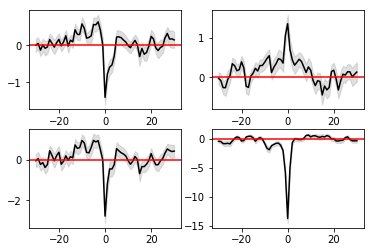

In [535]:
# Now summarise the profile - noting that nsuc gives us the number of members in our sample
fig,ax=plt.subplots(2,2)
x=range(-30,31)
vs=[temp_anom[:,:nsuc],hum_anom[:,:nsuc],hi_anom[:,:nsuc],slp_anom[:,:nsuc]]
denom=np.sqrt(nsuc)
count=0
for v in vs:
    mu=np.mean(v,axis=1)
    std=np.std(v,axis=1)
    sterr=std/denom
    ax.flat[count].fill_between(x,mu-sterr,mu+sterr,color="grey",alpha=0.25)
    ax.flat[count].plot(x,mu,color="k")
    ax.flat[count].axhline(0,color="red")
    count+=1; print count

### Silver Standard: AWSs logging HI only during TC passage (next 30 days) 

In [ ]:
# Use ulmo-modified code to extract met data for the station nearest the TC landfall
reload(tc)
ids=all_stations.keys() # station codes
latlon=np.array([[all_stations[ii]["latitude"],all_stations[ii]["longitude"]] for ii in ids],dtype=np.float) # coordinates
# Test now by extracting pressure 
outmet=[]
outmet_hit=[]
out_station=[]
out_pickle={}
dist_used=np.zeros((len(tcdata)))*np.nan
nsuc=0
with open(outfile_silver,"w") as fo:
    
    # Write the header to the output file
    fo.write("YEAR\tMONTH\tDAY\tID\tLAT\tLON\tSTATION_ID\tDIST\n")
    
    for loc in range(len(tcdata)):

        # If all criteria are met, we'll not search any more; initialise to "search"
        dist=GF.haversine_fast(tclat[loc],tclon[loc],latlon[:,0],latlon[:,1],miles=False) # that's the distance
        order=np.argsort(dist)
        nearest=0
        mindist=dist[order[nearest]]
        keep_search=True
        while keep_search and mindist<maxdist:

            # Construct date index for this landfall location
            # Note that in creating tc_date we range from 1 day after landfall (1st jan + JD_days = st_date+1)
            tc_date=datetime.date(year=int(tcdata[loc,1]),month=1,day=1)+\
            datetime.timedelta(days=np.floor(tcdata[loc,2]))
            tc_end=tc_date+datetime.timedelta(days=29)

            # Now extract all data for the year (+/-1) of TC landfall for the station closest to landfall location
            startyr=tc_date.year-1; endyr=tc_date.year+1
            alldata,corevars=tc.get_gsod_data("/media/gytm3/WD12TB/GSOD",\
            [ids[order[nearest]],],startyr=int(startyr), endyr=int(endyr), parameters=None)

            # Check we have something!
            if len(corevars)>1:     

                # Compute HI. etc
                corevars["tempC"]=GF.Faren2C(corevars["mean_temp"])
                corevars["dewC"]=GF.Faren2C(corevars["dew_point"])
                # Set to nan
                corevars.loc[corevars["mean_temp"]==9999.9,"tempC"]=np.nan
                corevars.loc[corevars["dew_point"]==9999.9,"dewC"]=np.nan
                corevars.loc[np.logical_or(corevars["slp"]==9999.9,corevars["slp"]<800),"slp"]=np.nan
                corevars["rh"]=GF.dewVp(corevars["dewC"]+273.15)/GF.satVp(corevars["tempC"])*100.            
                corevars["specHum"]=GF.specHum(corevars["tempC"],corevars["rh"],corevars["slp"])
                corevars["hi"]=GF.HeatIndexNWS(corevars["tempC"],corevars["rh"],opt=False,iounit=np.array([0,0]))

                # Check for completion during "hit"
                hit_data=corevars[tc_date:tc_end]

                # Examine hi availability 
                n_hi=len(hit_data["hi"])

                # Then all data here
                if np.sum(~np.isnan(hit_data["hi"]))==30:
                    outmet.append(corevars)
                    outmet_hit.append(hit_data)
                    dist_used[loc]=dist[order[nearest]]
                    out_station.append(ids[order[nearest]])
                    
                    
                    # **********************************************************
                    # Save the met data in a dictionary: key = tc_id-date; 
                    # entry = [station id, station lat, station lon, 31 day HI ]
                    # ********************************************************** 

                    key_date=tc_date-datetime.timedelta(days=1) # shift back by one day for landfall
                    key="%.0f_%.0f-%02d-%02d" %(tcdata[loc,0],key_date.year,key_date.month,key_date.day)
                    
                    out_pickle[key]\
                    =[ids[order[nearest]],all_stations[ids[order[nearest]]]["latitude"],\
                      all_stations[ids[order[nearest]]]["longitude"],hit_data["hi"].values]
                    
                    
                    hit_data.to_csv(odir_silver\
                    +key+".csv",float_format="%.4f"); print "written file: %.0f!" % nsuc
                    
                    # Also figure out the max HI as we pass! 
                    maxhi=hit_data["hi"].max()
                    if maxhi>40.6:
                        print "\n***\nTC %.0f exceeded 40.6C!\n***\n" % tcdata[loc,0]
                    
                    # End search
                    keep_search=False; print "Found what we're after! [dist=%.1f; station=%s]" \
                    % (dist[order[nearest]],ids[order[nearest]])
                    nsuc+=1
                    
                    # Write a new line out
                    lout="%.0f\t%.0f\t%.0f\t%.0f\t%.2f\t%.2f\t%s\t%.2f\n" % \
                    (tc_date.year,tc_date.month,tc_date.day,\
                     tcdata[loc,0],tcdata[loc,3],tcdata[loc,4],ids[order[nearest]],dist[order[nearest]])
                    fo.write(lout); fo.flush()

            if keep_search:
                mindist=dist[order[nearest+1]]
                print "Didn't satisfy criteria [dist=%.1f; nhi=%.0f]; moving to distance: %.1f" % \
                    (dist[order[nearest]],n_hi,mindist)


            nearest+=1  
        print "Finished with loc %.0f" % loc
        
# Pickle all these station data
pickle.dump(out_pickle,open("StationData_PostTC.p","wb"))

In [18]:
key

'9214_1980-11-04'

Now, with this "silver" output written to file (HI in 30-days following landfall), compare to the HI as estimated 
by WFDEI. 

The method here is to iterate over the netcdf WFDEI file, in which each location is the main dimension; time, latitude and longitude are parallel dimensions. 

In [8]:
# Number of days after TC we're interested in...
ndays=30  


# Define WFDEI data
metfile="/media/gytm3/WD12TB/TropicalCyclones/TC-DeadlyHeat/Data/TC_met_all.nc"
meto=Dataset(metfile,"r")

# Define NCEP data
metfile_ncep="/media/gytm3/WD12TB/TropicalCyclones/TC-DeadlyHeat/Data/NCEP_II_TC_met_all.nc"
meto_ncep=Dataset(metfile_ncep,"r")

# Get ntime and nlocs
ntime,nlocs=meto.variables["hi"].shape
time=meto.variables["time"]
yr,mon,day,hr,dt=\
GF.conTimes(time_str=time.units,calendar="standard",\
                    times=time[:],safe=False)
grid_times=np.floor(tc.dt2decday(dt)) # decimal time (WFDEI)

# Read in the pickled AWS data
# structure: {tcid_yy-mm-dd: [station id, lat, lon, 31 values]
aws_data=pickle.load(open("StationData_PostTC.p","rb"))
aws_keys=aws_data.keys()


# Make substitutions for clearer code
tc_yy=tcdata[:,1]
tc_jd=np.floor(tcdata[:,2])
nim=0
hi_out=np.zeros((nlocs,ndays))
hi_out_pop=np.zeros((nlocs,3))
tcid=tcdata[:,0]
comp=np.zeros((len(tcdata),6))
stdvs=np.zeros((len(tcdata),2))
nmatch=0
for ll in range(nlocs):
        
        
        #if tc_yy[ll]==2017 and tc_jd[ll]>(365-ndays): continue # because ndays window will trigger an 
            # out-of-bounds error
            
        if (tc_yy[ll]>=2015 and tc_jd[ll]>(365-ndays)) or tc_yy[ll]>2015: continue
        
        # Get time index in nc file - based on time in tcdata (of landfall)
        idx=np.logical_and(yr==tcdata[ll,1],np.logical_and(grid_times>=tc_jd[ll]+1,grid_times<=tc_jd[ll]+ndays))
        n=np.sum(idx)
        
        if n <ndays: # then we need to "wrap" around to the BEGINNING of the NEXT year
            idx=np.logical_or(idx,np.logical_and(yr==tcdata[ll,1]+1,grid_times<=ndays-n))
            
        # Store raw hi series
        hi_out[ll,:]=meto.variables["hi"][idx,ll]
        
        # Check that we're reading the right TC!
        assert meto.variables["id"][ll]==tcdata[ll,0]
        
        # Create datetime object of time of landfall
        tc_date=datetime.date(year=int(tcdata[ll,1]),month=1,day=1)+\
            datetime.timedelta(days=np.floor(tcdata[ll,2])-1)
        
        # Now retrieve the AWS data using the id_yy-mm-dd as the key
        
        key = "%.0f_%.0f-%02d-%02d"%(tcdata[ll,0], tc_date.year,tc_date.month,tc_date.day)
        if key in aws_keys: 
            aws_ii = aws_data[key]
            
            # Open the .csv file with the full aws met info
            test=pd.read_csv(odir_silver+key+".csv",index_col=0,parse_dates=True)
            
            # Check alignment of dates
            assert test.index[0].to_pydatetime().date()==dt[idx][0].date()
            
            # Put in grid data for comparisons/correlations
            test["grid_tempC"]=meto.variables["Tair"][idx,ll]-273.15
            test["grid_rh"]=meto.variables["Qair"][idx,ll]/GF.specHum(meto.variables["Tair"][idx,ll],\
                                                      np.ones(30)*100,\
                                                      meto.variables["PSurf"][idx,ll])*100
            test["grid_press"]=meto.variables["PSurf"][idx,ll]/100.
            test["grid_hi"]=meto.variables["hi"][idx,ll]
            
            # Add ncep data
            test["ncep_grid_tempC"]=meto_ncep.variables["Tair"][idx,ll]-273.15
            test["ncep_grid_rh"]=meto_ncep.variables["Qair"][idx,ll]/GF.specHum(meto.variables["Tair"][idx,ll],\
                                                      np.ones(30)*100,\
                                                      meto.variables["PSurf"][idx,ll])*100
            test["ncep_grid_press"]=meto_ncep.variables["PSurf"][idx,ll]/100.
            test["ncep_grid_hi"]=meto_ncep.variables["hi"][idx,ll]            
            
            # Compute all correlations: 
            rs=test.corr()

            
            # Perform correlations etc
            comp[nmatch,0]=rs["hi"]["grid_hi"]
            comp[nmatch,1]=rs["slp"]["grid_press"]
            comp[nmatch,2]=test["slp"].mean()-test["grid_press"].mean()
            comp[nmatch,3]=GF.haversine((tcdata[ll,5],tcdata[ll,6]), (aws_ii[1],aws_ii[2]), miles=False)
            comp[nmatch,4]=rs["hi"]["ncep_grid_hi"]
            comp[nmatch,5]=rs["grid_hi"]["ncep_grid_hi"]
            #comp[nmatch,4]=meto.variables["stdv"][ll]
                    
            
            # Bad matches
            if comp[nmatch,0]<0.25: # then BIG rmse, and we should inspect the files...

                test.to_csv(testdir+"bad_"+key+".csv",float_format="%.4f")
                            
            # Goodp matches
            if comp[nmatch,0]>0.75:

                test.to_csv(testdir+"good_"+key+".csv",float_format="%.4f")

            
            nmatch+=1
        nim+=1      
        
                     
# Truncate as necessary
hi_out=hi_out[:nim,:]
comp=comp[:nmatch,:]
#print np.nanmean(comp[:,1]), np.max(comp[:,-1])
stdvs=stdvs[:nmatch,:]
#plt.scatter(comp[:,-1],comp[:,1]) 
#plt.scatter(comp[:,-1],comp[:,0])

# print means for WFDEI and NCEP hi
print "NCEP:",np.nanmean(comp[:,4]),"WFDEI:",np.nanmean(comp[:,0])
print "NCEP/WFDEI:",np.nanmean(comp[:,5])

NCEP: 0.4517361783028493 WFDEI: 0.6051830799940643
NCEP/WFDEI: 0.5205495519857826


Notes: there is very low correlation (and high RMSE) for quite a few stations. We need to try to figure out whether this is due to a data processing error, or if it reflects some sort of limitation in the WFDEI data...

So far: 

- the raw data look to be sensible (inspection of individual files based on low r)

next: 
- repeat for high RMSE (>10 C)
- explore if corrrelation error is f(var)



In [6]:
rs

,dew_point,mean_temp,slp,tempC,dewC,rh,specHum,hi,grid_tempC,grid_rh,grid_press,grid_hi,ncep_grid_tempC,ncep_grid_rh,ncep_grid_press,ncep_grid_hi
dew_point,1.000000,0.756127,-0.315401,0.756120,1.000000,0.386222,0.999162,0.856929,0.510424,0.302613,-0.245827,0.711377,0.626809,-0.032410,-0.187640,0.451654
mean_temp,0.756127,1.000000,-0.160920,1.000000,0.756126,-0.311317,0.753224,0.978334,0.691267,-0.084080,-0.130624,0.754310,0.691298,-0.323893,0.049548,0.503141
slp,-0.315401,-0.160920,1.000000,-0.160910,-0.315401,-0.233251,-0.325932,-0.194482,0.045148,0.000099,0.948470,0.087590,-0.059216,0.214988,0.780252,-0.057681
tempC,0.756120,1.000000,-0.160910,1.000000,0.756119,-0.311326,0.753217,0.978331,0.691268,-0.084082,-0.130614,0.754310,0.691303,-0.323895,0.049559,0.503147
dewC,1.000000,0.756126,-0.315401,0.756119,1.000000,0.386223,0.999162,0.856928,0.510427,0.302611,-0.245829,0.711380,0.626814,-0.032409,-0.187641,0.451662
rh,0.386222,-0.311317,-0.233251,-0.311326,0.386223,1.000000,0.388749,-0.135637,-0.239347,0.567244,-0.170994,-0.034290,-0.063878,0.419754,-0.345451,-0.052273
specHum,0.999162,0.753224,-0.325932,0.753217,0.999162,0.388749,1.000000,0.857063,0.518187,0.286734,-0.257625,0.712975,0.623287,-0.045588,-0.193453,0.446771
hi,0.856929,0.978334,-0.194482,0.978331,0.856928,-0.135637,0.857063,1.000000,0.706050,-0.022582,-0.155425,0.798601,0.704107,-0.291714,0.001506,0.505529
grid_tempC,0.510424,0.691267,0.045148,0.691268,0.510427,-0.239347,0.518187,0.706050,1.000000,-0.497416,0.039518,0.901054,0.553146,-0.536313,0.301320,0.405942
grid_rh,0.302613,-0.084080,0.000099,-0.084082,0.302611,0.567244,0.286734,-0.022582,-0.497416,1.000000,0.039908,-0.084076,0.027451,0.745792,-0.271532,0.049898


In [142]:
comp[nmatch-1,1]

2.157507640300983

In [127]:
dt[idx][0].date()

datetime.date(1980, 11, 5)

In [169]:
comp[:,1]

array([0.92817924, 0.91650818, 0.91322469, 0.9851781 , 0.99495339,
       0.98458259, 0.97737927, 0.87252139, 0.98138062, 0.94460368,
       0.95629671, 0.94941602, 0.98293742, 0.95611458, 0.97106665,
       0.91599396, 0.70129011, 0.98776799,        nan,        nan,
       0.88852802,        nan,        nan,        nan, 0.99076992,
       0.99567998, 0.59852508, 0.8952813 , 0.94379799, 0.98841191,
       0.99126389, 0.90180635, 0.89713253, 0.99354485, 0.98887046,
       0.99393727, 0.96917292, 0.91583188, 0.98839221, 0.96361734,
       0.97840644, 0.98563948, 0.981756  , 0.92449613, 0.93309701,
       0.90358374,        nan, 0.92966093, 0.96385833, 0.98499576,
       0.9447489 , 0.96212425, 0.97744157, 0.98722868, 0.97950958,
       0.98321205, 0.9924881 , 0.97912317, 0.9946425 , 0.99444856,
       0.83936985, 0.84020047, 0.98659492, 0.98723472, 0.98220469,
       0.98663682, 0.9793026 , 0.98091324, 0.98616903, 0.8999523 ,
       0.99336968, 0.98773837, 0.97245652, 0.97240395,        